In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import keras.backend as K
from tensorflow.keras.applications import densenet
import tensorflow.keras.layers as kl
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Layer
#import keras_tuner
import humanfriendly
import itertools
import sklearn.metrics

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split, GroupShuffleSplit
#from keras_tuner.tuners import BayesianOptimization
#from keras_tuner import Objective
#from keras_tuner_cv.utils import pd_inner_cv_get_result

#Optimizer options
from tensorflow.keras.optimizers import Adam

2024-05-03 14:19:59.047393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 14:20:00.402407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.utils import resample

In [3]:
import tensorflow as tf
import cv2
from imgaug import augmenters as iaa
from skimage.exposure import match_histograms

import collections
collections.Iterable = collections.abc.Iterable
import numpy as np
import random
np.bool = np.bool_
np.complex = np.complex_

import argparse
import os
import sys
import time

In [4]:
os.chdir("/localscratch/hrechter.20196411.0")

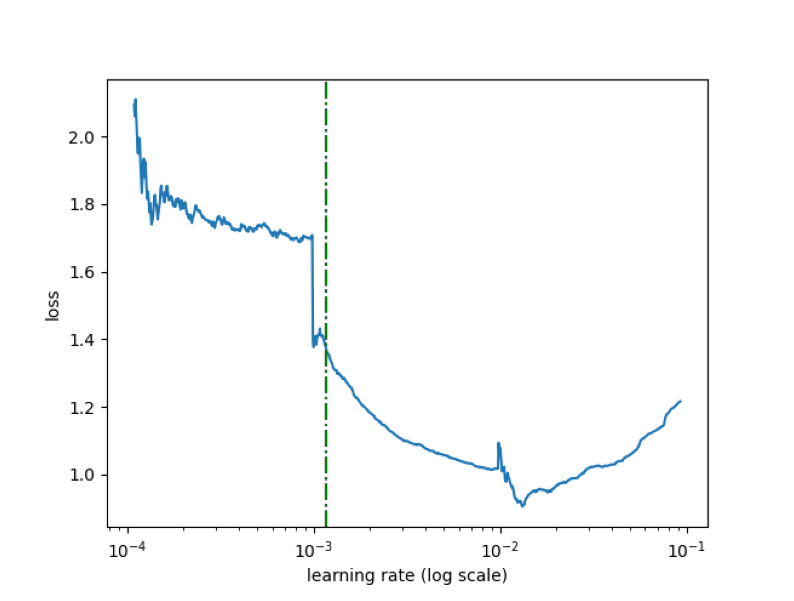

In [69]:
image = cv2.imread("Fig1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#%%
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
#%% Define mask insertion function
'''
Function from StackOverflow user Ben: https://stackoverflow.com/users/59850/ben
https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
'''
def add_transparent_image(background, foreground, x_offset=None, y_offset=None):
    bg_h, bg_w, bg_channels = background.shape
    fg_h, fg_w, fg_channels = foreground.shape

    assert bg_channels == 3, f'background image should have exactly 3 channels (RGB). found:{bg_channels}'
    assert fg_channels == 4, f'foreground image should have exactly 4 channels (RGBA). found:{fg_channels}'

    # center by default
    if x_offset is None: 
        x_offset = (bg_w - fg_w) // 2
    else:
        centre_x = (bg_w - fg_w) // 2
        x_offset = x_offset + centre_x
        
    if y_offset is None: 
        y_offset = (bg_h - fg_h) // 2
    else:
        centre_y = (bg_h - fg_h) // 2
        y_offset = y_offset + centre_y

    w = min(fg_w, bg_w, fg_w + x_offset, bg_w - x_offset)
    h = min(fg_h, bg_h, fg_h + y_offset, bg_h - y_offset)

    if w < 1 or h < 1: return

    # clip foreground and background images to the overlapping regions
    bg_x = max(0, x_offset)
    bg_y = max(0, y_offset)
    fg_x = max(0, x_offset * -1)
    fg_y = max(0, y_offset * -1)
    foreground = foreground[fg_y:fg_y + h, fg_x:fg_x + w]
    background_subsection = background[bg_y:bg_y + h, bg_x:bg_x + w]

    # separate alpha and color channels from the foreground image
    foreground_colors = foreground[:, :, :3]
#    foreground_colors = match_histograms(foreground_colors, background, channel_axis=-1)
    alpha_channel = foreground[:, :, 3] / 255  # 0-255 => 0.0-1.0

    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = background_subsection * (1 - alpha_mask) + foreground_colors * alpha_mask

    # overwrite the section of the background image that has been updated
    background[bg_y:bg_y + h, bg_x:bg_x + w] = composite
    return background

In [7]:
#%% Define augmentation functions
mask_augs = iaa.Sequential([iaa.Resize((0.45, 0.85), interpolation="area"), #area interpolation is best for shrinking images
        iaa.SomeOf((1, 2), [  # Random number between 0, 2
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        iaa.Rotate((-10, 10)),
        ], random_order=True)], random_order = True)

Winter_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.weather.Clouds(),
        iaa.weather.Fog(),
        iaa.weather.Snowflakes()
        ], random_order=True)

small_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        iaa.Multiply((0.95, 1.05), per_channel=0.2),  # Brightness multiplier per channel    0.05
        iaa.Grayscale(alpha=(0.1, 1.0)),  # Random Grayscale conversion          0.17        
        iaa.LinearContrast((0.75, 1.5)),  # Contrast Normalization               0.95
        ], random_order=True)

train_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        # Random channel increase and rotation 0.03
        iaa.Add((-5, 5)),  # Overall Brightness                   0.04
        iaa.Multiply((0.95, 1.05), per_channel=0.2),  # Brightness multiplier per channel    0.05
        iaa.Sharpen(alpha=(0.1, 0.75), lightness=(0.85, 1.15)),  # Sharpness                            0.05
        iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',  # Random HSV increase                  0.09
                           children=iaa.WithChannels(0, iaa.Add((-30, 30)))),
        iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',
                           children=iaa.WithChannels(1, iaa.Add((-30, 30)))),
        iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',
                           children=iaa.WithChannels(2, iaa.Add((-30, 30)))),
        iaa.AddElementwise((-10, 10)),  # Per pixel addition                   0.11
        iaa.CoarseDropout((0.0, 0.02), size_percent=(0.02, 0.25)),  # Add large black squares              0.13
        iaa.GaussianBlur(sigma=(0.1, 1.0)),  # GaussianBlur                         0.14
        iaa.Grayscale(alpha=(0.1, 1.0)),  # Random Grayscale conversion          0.17
        iaa.Dropout(p=(0, 0.1), per_channel=0.2),  # Add small black squares              0.17
        iaa.AdditiveGaussianNoise(scale=(0.0, 0.05 * 255), per_channel=0.5),
        # Add Gaussian per pixel noise         0.26
        iaa.ElasticTransformation(alpha=(0, 1.0), sigma=0.25),  # Distort image by rearranging pixels  0.70
        iaa.LinearContrast((0.75, 1.5)),  # Contrast Normalization               0.95
        iaa.weather.Clouds(),
        iaa.weather.Fog(),
  #      iaa.weather.Rain()
    ], random_order=True)

nightnoise = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(0, 5))])

In [8]:
#%%
class TrainingDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, crops, X_col, y_col,
                 batch_size, model_name,
                 shuffle=True, INSERTS=False, SPP_BAL=False,
                 weights=None, night_weights=None):

        self.df = df.copy()
        self.crops = crops.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.model = model_name
        self.INSERTS=INSERTS
        self.n = len(self.df)
        if self.INSERTS==False:
            self.n_id = df[y_col['id']].nunique()
        elif self.INSERTS==True:
            self._weights=weights
            self._night_weights=night_weights
            if self.df['id'].isin([-2]).any():
                self.n_id = ((df[y_col['id']].nunique())-2)
                if SPP_BAL == False:
                    self._weights=weights
                    self._night_weights=night_weights
                else:
                    self._weights=None
                    self._night_weights=None
            else:
                self.n_id = ((df[y_col['id']].nunique())-1)
            if self.n_id>12:
                day_choices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32, 33, 34, 35]
                night_choices=[0, 1, 2, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33]
        self.n_domain = df[y_col['domain']].nunique()


    # Shuffling upon epoch end if flagged
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __insert_augs(self, path, night, spp):
 #       start_time = time.time()
        if spp==-1:
            if night==False:
        #        rolld8=np.random.choice([0, 1, 2, 3, 4, 5, 6, 7], p=self._weights)
                rolld8=(random.choices([0, 1, 2, 3, 4, 5, 6, 7], weights=self._weights, k=1))[0]
                if rolld8==0:
                    image = tf.keras.utils.load_img(path)
                    image_arr = tf.keras.utils.img_to_array(image)
                    species=0
           #         SKIP = time.time() - start_time
            #        print(('SKIP: {}.').format(SKIP))
                    return image_arr, species
#                SELECT = time.time()
                crop_index = self.crops.loc[(self.crops.Night==False) & (self.crops.id==rolld8)].sample(n=1).index.item()
#                SELECT_IMAGE = time.time() - SELECT
 #               FIND_INDEX = time.time() - start_time
  #              print(('SELECT IMAGE time: {}.').format(SELECT_IMAGE))
   #             print(('FIND DAY INDEX time: {}.').format(FIND_INDEX))
    #            insert_start = time.time()
                cpath = self.crops.iloc[crop_index, 0]
     #           READ_CPATH = time.time() - insert_start
      #          print(('READ CROP PATH time: {}.').format(READ_CPATH))
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
       #         openCROP = time.time() - insert_start
        #        print(('OPEN CROP time: {}.').format(openCROP))
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]
                
                crop_aug = mask_augs.augment_image(crop)
#                augCROP = time.time() - insert_start
 #               print(('AUGMENT CROP time: {}.').format(augCROP))
                
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
                image = cv2.imread(path)
  #              OPEN_IMPATH = time.time() - insert_start
   #             print(('OPEN IMAGE PATH time: {}.').format(OPEN_IMPATH))
    #            ADD_TRANSPARENT_START = time.time()
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)
     #           ADD_TRANSPARENT_ELAPSED = time.time() - ADD_TRANSPARENT_START
      #          print(('Add_transparent_image DAY time: {}.').format(ADD_TRANSPARENT_ELAPSED))
          #      image_og = cv2.imread(path)
         #       image = match_histograms(image, image_og, channel_axis=-1)
            elif night==True:
           #     nightd7=np.random.choice([0, 1, 2, 3, 4, 6, 7], p=self._night_weights)
                nightd7=(random.choices([0, 1, 2, 3, 4, 6, 7], weights=self._night_weights, k=1))[0]
                if nightd7==0:
                    image = tf.keras.utils.load_img(path)
                    image_arr = tf.keras.utils.img_to_array(image)
                    species=0
#                    SKIP = time.time() - start_time
 #                   print(('SKIP: {}.').format(SKIP))
                    return image_arr, species
#                SELECT = time.time()
                crop_index = self.crops.loc[(self.crops.Night==True) & (self.crops.id==nightd7)].sample(n=1).index.item()
 #               SELECT_IMAGE = time.time() - SELECT
  #              FIND_INDEX = time.time() - start_time
   #             print(('SELECT IMAGE time: {}.').format(SELECT_IMAGE))
    #            FIND_INDEX = time.time() - start_time
     #           print(('----------------find night index time: {}.').format(FIND_INDEX))
      #          insert_start = time.time()
                cpath = self.crops.iloc[crop_index, 0]
#                READ_CPATH = time.time() - insert_start
 #               print(('READ CROP PATH time: {}.').format(READ_CPATH))
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
  #              openCROP = time.time() - insert_start
   #             print(('OPEN CROP time: {}.').format(openCROP))
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]
                crop_aug = mask_augs.augment_image(crop)
    #            augCROP = time.time() - insert_start
     #           print(('AUGMENT CROP time: {}.').format(augCROP))
                
                
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
#                READ_PATH = time.time() - insert_start
                image = cv2.imread(path)
 #               OPEN_IMPATH = time.time() - insert_start
  #              print(('OPEN IMAGE PATH time: {}.').format(OPEN_IMPATH))
   #             ADD_TRANSPARENT_START = time.time()
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)
    #            ADD_TRANSPARENT_ELAPSED = time.time() - ADD_TRANSPARENT_START
     #           print(('----------------Add_transparent_image night time: {}.').format(ADD_TRANSPARENT_ELAPSED))
        #        image = nightnoise.augment_image(image)
#            FINAL_MODS_START = time.time()
            image = cv2.rectangle(image, (0,0), (244,52), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
            image = cv2.rectangle(image, (0,172), (244,244), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
 #           FINAL_MODS = time.time() - FINAL_MODS_START
  #          print(('BLACKOUT BARS time: {}.').format(FINAL_MODS))
            
            rolld100=random.randint(1, 101)
            if rolld100==100: #Save 1% of created images for verification
   #             start_save = time.time()
                file = path.rsplit('/')[-1]
                spp_name = self.crops.iloc[crop_index, 2]
                if not os.path.exists("Results/augmentations/"):
                    os.makedirs("Results/augmentations/")
                cv2.imwrite("Results/augmentations/" + spp_name + "_" + file, image)
    #            SAVE_elapsed = time.time() - start_save
     #           print(('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>d100 save time: {}.').format(SAVE_elapsed))
            image_arr = image.astype("float32")
            species = self.crops.iloc[crop_index, 3]
      #      INSERT_elapsed = time.time() - insert_start
       #     AUGMENT_elapsed = time.time() - start_time
        #    print(('Animal Insert time: {}.').format(INSERT_elapsed))
         #   print(('FULL AUGMENTATION time: {}.').format(AUGMENT_elapsed))
            return image_arr, species
        if spp==-2:
            if night==False:
                rolld8=(random.choices([0, 1, 2, 3, 4, 5, 6, 7], weights=self._weights, k=1))[0]
                if rolld8==0:
                    image = tf.keras.utils.load_img(path)
                    image_arr = tf.keras.utils.img_to_array(image)
                    species=0
                    return image_arr, species

                crop_index = self.crops.loc[(self.crops.Night==False) & (self.crops.id==rolld8)].sample(n=1).index.item()
                cpath = self.crops.iloc[crop_index, 0]
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]
                
                crop_aug = mask_augs.augment_image(crop)
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
                image = cv2.imread(path)
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)

          #      image_og = cv2.imread(path)
         #       image = match_histograms(image, image_og, channel_axis=-1)
            elif night==True:
                nightd7=(random.choices([0, 1, 2, 3, 4, 6, 7], weights=self._night_weights, k=1))[0]
                if nightd7==0:
                    image = tf.keras.utils.load_img(path)
                    image_arr = tf.keras.utils.img_to_array(image)
                    species=0
                    return image_arr, species

                crop_index = self.crops.loc[(self.crops.Night==True) & (self.crops.id==nightd7)].sample(n=1).index.item()
                cpath = self.crops.iloc[crop_index, 0]
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]

                crop_aug = mask_augs.augment_image(crop)
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
                image = cv2.imread(path)
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)
        #        image = nightnoise.augment_image(image)

            image = cv2.rectangle(image, (0,0), (244,52), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
            image = cv2.rectangle(image, (0,172), (244,244), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
            
            rolld100=random.randint(1, 101)
            if rolld100==100: #Save 1% of created images for verification
                file = path.rsplit('/')[-1]
                spp_name = self.crops.iloc[crop_index, 2]
                if not os.path.exists("Results/augmentations2/"):
                    os.makedirs("Results/augmentations2/")
                cv2.imwrite("Results/augmentations2/" + spp_name + "_" + file, image)

            image_arr = image.astype("float32")
            species = self.crops.iloc[crop_index, 3]
            return image_arr, species

    #Reads image and normalizes it
    def __get_input(self, path):
        image = tf.keras.utils.load_img(path)
        image_arr = tf.keras.utils.img_to_array(image)
        image_arr = small_aug.augment_image(image_arr.astype("uint8")).astype("float32")
        return image_arr/255

    #Reads image and normalizes it
    def __get_insert_input(self, x):
        path=x[0]
        night=x[1]
        spp=x[2]

        if spp in (-1, -2):
            image_arr, x[2] = self.__insert_augs(path, night, spp)
        else:
            image = tf.keras.utils.load_img(path)
            image_arr = tf.keras.utils.img_to_array(image)
        image_arr = small_aug.augment_image(image_arr.astype("uint8")).astype("float32")
        spp = x[2]
        label = tf.keras.utils.to_categorical(spp, 8)
        return image_arr/255, label

    #One-hot encoding of label
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    #Generates batch_size samples of data
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['path']]
        name_batch = batches[self.y_col['id']]

        if self.INSERTS==True:
            night_batch = batches[self.X_col['Night']]
            x_batches=np.array([path_batch, night_batch, name_batch])
            x_batches=np.stack(x_batches,axis=1)

            batch_tuple = np.asarray([self.__get_insert_input(x) for x in x_batches])
            X_batch, y0_batch = zip(*batch_tuple)
            X_batch = np.array(X_batch)
            y0_batch= np.array(y0_batch)

        else:
            X_batch = np.asarray([self.__get_input(x) for x in path_batch])
            y0_batch = np.asarray([self.__get_output(y, self.n_id) for y in name_batch])

        if self.model in ('DenseNet201', 'CNN'):
            return X_batch, y0_batch
        elif self.model in ('DANNseNet201', 'DANN'):
            sin_season_batch = batches[self.y_col['sin_date']]
            cos_season_batch = batches[self.y_col['cos_date']]
            y1_batch = np.asarray([y for y in zip(sin_season_batch, cos_season_batch)])
            return X_batch, tuple([y0_batch, y1_batch])
        elif self.model in ('CatDANN', 'catDANN'):
            domain_batch = batches[self.y_col['domain']]
            y1_batch = np.asarray([self.__get_output(y, 4) for y in domain_batch])
            return X_batch, tuple([y0_batch, y1_batch])

    #Returns data batches as tuple
    def __getitem__(self, index):

        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)    

        return X, y

    #Returns number of batches
    def __len__(self):
        return self.n // self.batch_size

In [9]:
class ValidationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size, model_name,
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.model = model_name
        self.n = len(self.df)
        self.n_id = ((df[y_col['id']]).nunique())
        self.n_domain = df[y_col['domain']].nunique()
    # Shuffling upon epoch end if flagged
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    #Reads image and normalizes it
    def __get_input(self, path):

        image = tf.keras.utils.load_img(path)
        image_arr = tf.keras.utils.img_to_array(image)
        return image_arr/255.
   
    #One-hot encoding of label
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    #Generates batches of data
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['path']]
        name_batch = batches[self.y_col['id']]
        X_batch = np.asarray([self.__get_input(x) for x in path_batch])
        y0_batch = np.asarray([self.__get_output(y, self.n_id) for y in name_batch])

        if self.model in ('DenseNet201', 'CNN'):
            return X_batch, y0_batch
        elif self.model in ('DANNseNet201', 'DANN'):
            sin_season_batch = batches[self.y_col['sin_date']]
            cos_season_batch = batches[self.y_col['cos_date']]
            y1_batch = np.asarray([y for y in zip(sin_season_batch, cos_season_batch)])
            return X_batch, tuple([y0_batch, y1_batch])
        elif self.model in ('CatDANN', 'catDANN'):
            domain_batch = batches[self.y_col['domain']]
            y1_batch = np.asarray([self.__get_output(y, 4) for y in domain_batch])
            return X_batch, tuple([y0_batch, y1_batch])
    
    #Returns data batches as tuple
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)    
        
        return X, y
    
    #Returns number of batches
    def __len__(self):
        return self.n // self.batch_size

In [10]:
from lrfinder import LRFinder

In [11]:
df = pd.read_csv("AHC_all.csv")
#df['id'] = df['id']-1
#allAHC = pd.read_csv("AHC_all.csv")
#allAHC['id'] = allAHC['id']-1
crops = pd.read_csv("crops.csv")
empties = pd.read_csv("empties.csv")

In [12]:
def get_group(train_df, group):
    """
    Stratified Group K-fold cross validation requires an extra group around which to split the data.
    This function returns that group data as an array. 
    
    Inputs:
    - traindf: str, the metadata CSV containing annotations for the images. 
    
    - group: str, set which location margin to divide the dataset by for cross validation.
    Options: 
        - "CTloc" - K-fold will split data down to singular CT stations. This is the smallest split of data.
        - "CTtype" - K-fold will split data down to CT study area and area type, three per CT area. ie. PT_RAF, PT_TRV, PT_ROW.
        - "areatype" - K-fold will split data down to area type, three overall. ie. RAF, TRV, ROW.
        - "studyarea" - K-fold will split data down to CT study area. This is the largest split of all data. ie. PT, SC, SV, GL.
    
    Returns:
        out (numpy.ndarray): array-like of shape [n_samples,]
        
    """
    
 #   train_df = pd.read_csv(traindf)

    if group in ("CTloc"):
        CTloc_train = np.array(train_df['Camera_loc'])
        return CTloc_train
    elif group in ("CT_loc"):
        CTtype_train = np.array(train_df['CT_location'])
        return CTtype_train
    elif group in ("Ecoregion"):
        Ecoregion_train = np.array(train_df['Ecoregion'])
        return Ecoregion_train
    elif group in ("studyarea"):
        studyarea_train = np.array(train_df['study_area'])
        return studyarea_train
    

In [13]:
#%%
def model_build():
    model = densenet.DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling="avg")
    model.trainable = False
    regularizer = None
    
    out = kl.Dense(256, activation="relu", kernel_regularizer=regularizer)(model.layers[-1].output)
    out = kl.Dropout(0.0)(out)

    out = kl.Dense(256, activation='relu')(out)
    out = kl.Dropout(0.0)(out)

    spp_class = kl.Dense(num_classes, activation='softmax', name="spp_class")(out)

    model = tf.keras.Model(inputs=model.inputs,
                           outputs=spp_class)

    return model

In [14]:
def plot_loss(n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

In [15]:
#%%
def upsample_data(train_df, MAX_SAMPLE=80000):
    
    sample_size = (MAX_SAMPLE)-len(train_df)
    
    train_sample = pd.DataFrame()

    temp = resample(train_df, 
                    replace=True,           # sample with replacement
                    n_samples=MAX_SAMPLE,          # to match majority class
                    random_state=42,        # reproducible results
                    stratify=train_df['path']) #must sample unique items before replacement
    
            # Combine majority class with upsampled minority class
    train_sample = pd.concat([train_sample, temp])
 
    return train_sample

In [16]:
def get_empties(train_df, train_empties, MAX_SAMPLE=80000, LOC_BAL=False, NIGHT_BAL=False):
    
    if NIGHT_BAL == True:
        n_loc = train_empties.Loc_ToD.nunique()
        column="Loc_ToD"
    else:
        n_loc = train_empties.Camera_loc.nunique()
        column="Camera_loc"
    train_sample = (MAX_SAMPLE)-len(train_df)
    sample_size = int(MAX_SAMPLE/n_loc)
    
    empty_sample = pd.DataFrame()

    if LOC_BAL == True:
        for cat in train_empties[column].unique():
            empties_df = train_empties[train_empties[column] == cat]
            df = train_df[train_df[column]==cat]
            CT_sample = sample_size-len(df)
            if CT_sample <=1:
                CT_sample=1
            temp = resample(empties_df, 
                            replace=True,           # sample with replacement
                            n_samples=CT_sample,          # to match majority class
                            random_state=42,        # reproducible results
                            stratify=empties_df['path']) #must sample unique items before replacement
    
            # Combine majority class with upsampled minority class
            empty_sample = pd.concat([empty_sample, temp])
    else:
        if NIGHT_BAL == True:
            for cat in train_empties['Night'].unique():
                empties_df = train_empties[train_empties['Night'] == cat]
                CT_sample = int((MAX_SAMPLE-len(train_df))/2)
                if CT_sample <=1:
                    CT_sample=1
                
                temp = resample(empties_df, 
                                replace=True,           # sample with replacement
                                n_samples=CT_sample,          # to match majority class
                                random_state=42,        # reproducible results
                                stratify=empties_df['path']) #must sample unique items before replacement

            # Combine majority class with upsampled minority class
            empty_sample = pd.concat([empty_sample, temp])
            
        else:
            empties_df = train_empties
            CT_sample = int(MAX_SAMPLE-len(train_df))
            if CT_sample <=1:
                CT_sample=1

            temp = resample(empties_df, 
                            replace=True,           # sample with replacement
                            n_samples=CT_sample,          # to match majority class
                            random_state=42,        # reproducible results
                            stratify=empties_df['path']) #must sample unique items before replacement

        # Combine majority class with upsampled minority class
        empty_sample = pd.concat([empty_sample, temp])
 
    return empty_sample

In [17]:
Y = np.array(df['id'])
num_classes = 8
BATCH=64

In [18]:
model = model_build()

2024-05-03 14:20:34.763594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:66:00.0, compute capability: 7.0


In [19]:
lr=1e-5
opt=Adam(learning_rate=lr)
loss="categorical_crossentropy"

metrics=["accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
train, test_df = train_test_split(df, test_size=0.10, random_state=42, stratify=df['id'])

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Y = np.array(train['id'])
group=None

In [20]:
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=4)
split = splitter.split(df, y=Y, groups=df['CT_location'])
train_index, test_index = next(split)
train = df.iloc[train_index]
test_df = df.iloc[test_index]
group = get_group(df, "CT_loc")
test_group = np.unique(group[test_index])

In [21]:
kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
Y = np.array(train['id'])
group = get_group(train, "CT_loc")
group_name="CTloc"

In [22]:
def get_train_weights(train_df, empties_length, SPP_BAL=True):
    class_weights = []
    night_weights=[]
    n_spp = train_df.id.nunique()
    if SPP_BAL==True:
        max_id_count = empties_length/n_spp
        for i in range(0, n_spp):
            class_weights.append((max_id_count - len(train_df.loc[train_df['id']==i]))/empties_length)
            if i !=5:
                night_weights.append((max_id_count - len(train_df.loc[train_df['id']==i]))/empties_length)
    else:
        for i in range(0, n_spp):
            class_weights.append((len(train_df.loc[train_df['id']==i]))/len(train_df))
            if i !=5:
                night_weights.append((len(train_df.loc[train_df['id']==i]))/len(train_df))
#    dw = sum(class_weights)
#    class_weights= [x/dw for x in class_weights]
#    nw = sum(night_weights)
#    night_weights= [x/nw for x in night_weights]
    return class_weights, night_weights

In [23]:
BATCH=64
INSERTS=False
SPP_BAL=False
NIGHT_BAL=False
LOC_BAL=False
UPSAMPLE=False
ADD_UNSEEN=False
MAX_SAMPLE=80000

In [24]:
for split, (train_index, val_index) in enumerate(kfold.split(train, Y, group)):
    print(f"Fold {split}:")

    train_df = train.iloc[train_index]
    val_df = train.iloc[val_index]

    train_count=len(train_df)
    val_count=len(val_df)
    train_prop = round((train_count/(train_count+val_count)), 3)
    val_prop = round((val_count/(train_count+val_count)), 3)
    
    if group is not None:
      #  print("Training groups: ", flush=True)
      #  print((np.unique(group[train_index])), flush=True)
      #  print(f"    Train count: {train_count}, train percentage: {train_prop}.", flush=True)
#                    print(train_df[['Species', 'id']].value_counts().reset_index(name='count'), flush=True)
        train_group = np.unique(group[train_index])

        print("\n" + "Validation groups: ", flush=True)
        print((np.unique(group[val_index])), flush=True)
        print(f"    Val count: {val_count}, val percentage: {val_prop}", flush=True)
#                     print(val_df[['Species', 'id']].value_counts().reset_index(name='count'), flush=True)
        val_group = np.unique(group[val_index])
    if INSERTS==True:
        if group_name in ("CTloc"):
            train_empties=empties.loc[empties['CT_location'].isin(train_group)]
            train_empties.loc[:,'id'] = -1
            if ADD_UNSEEN ==True:
                val_empties=empties.loc[empties['CT_location'].isin(val_group)]
                val_empties.loc[:,'id'] = -2
                test_empties=empties.loc[empties['CT_location'].isin(test_group)]
                test_empties.loc[:,'id'] = -2
                train_empties = pd.concat([train_empties, val_empties, test_empties])
            else:
                val_empties=None
                test_empties=None
        else:
            train_empties = empties.copy()
        train_empties=get_empties(train_df, train_empties, MAX_SAMPLE=MAX_SAMPLE, 
                                  LOC_BAL=LOC_BAL, NIGHT_BAL=NIGHT_BAL)

        if SPP_BAL==True:
            empties_length = len(train_empties.loc[train_empties['id']==-1])
            train_weights, night_weights = get_train_weights(train_df, empties_length, True)
            print(train_weights)
            print(night_weights)
        else:
            empties_length = len(train_empties.loc[train_empties['id']==-1])
            train_weights, night_weights = get_train_weights(train_df, empties_length, False)
            print(train_weights)
            print(night_weights)

    #                      print(np.unique(train_empties['id']))
    #                       print(np.unique(val_empties['id']))
        add_empties = [train_df, train_empties]
        train_df = pd.concat(add_empties)
        print(len(train_df))
    #                        print(len(train_df), flush=True)
    else:
        if UPSAMPLE==True:
            print(train_df[['Species', 'id']].value_counts().reset_index(name='count'), flush=True)
            print(train_df['path'].nunique())
            train_df = upsample_data(train_df, MAX_SAMPLE)
            print(train_df['path'].nunique())
        train_weights = None
        night_weights = None
    #  print(train_weights)
    #  print(night_weights)
    print("\n" + "Training data length: ", flush=True)
    print(len(train_df), flush=True)
    print(train_df[['Species', 'id', 'Night']].value_counts().reset_index(name='count'), flush=True)

Fold 0:

Validation groups: 
['GL_TRV001' 'GL_TRV004' 'GL_TRV007' 'GL_TRV008' 'PT_RAF001' 'PT_RAF003_2'
 'PT_RAF004' 'PT_RAF006' 'PT_ROW001' 'PT_TRV002' 'PT_TRV002_2' 'SC_RAF001'
 'SC_RAF003' 'SC_RAF004' 'SC_RAF007' 'SC_RAF008' 'SC_ROW005' 'SV_RAF002'
 'SV_RAF004' 'SV_ROW001' 'SV_ROW005' 'SV_TRV003' 'SV_TRV006']
    Val count: 2668, val percentage: 0.124

Training data length: 
18921
           Species  id  Night  count
0            empty   0  False   3758
1            empty   0   True   3677
2             deer   1  False   2403
3              fox   2   True   1961
4             deer   1   True   1521
5   sandhill crane   5  False   1467
6             bear   4  False   1074
7            moose   3   True   1016
8            moose   3  False    601
9              fox   2  False    374
10            wolf   6   True    349
11            bear   4   True    302
12            wolf   6  False    250
13          bobcat   7   True    136
14          bobcat   7  False     32
Fold 1:

Validation g

Epoch 1/3


2024-05-03 14:21:36.587491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-03 14:21:50.121872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-05-03 14:21:50.467937: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 14:21:50.485221: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 14:21:50.485347: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-03 14:21:50.494559: I tensorflow/tsl/

267/267 [==============================] - ETA: 0s - loss: 1.7081 - accuracy: 0.3982 - precision: 0.4475 - recall: 0.1303

2024-05-03 14:23:12.994864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


267/267 [==============================] - 111s 352ms/step - loss: 1.7081 - accuracy: 0.3982 - precision: 0.4475 - recall: 0.1303 - val_loss: 1.5884 - val_accuracy: 0.4397 - val_precision: 0.8333 - val_recall: 0.0257
Epoch 2/3
267/267 [==============================] - 88s 329ms/step - loss: 1.0173 - accuracy: 0.6336 - precision: 0.7312 - recall: 0.4945 - val_loss: 1.6066 - val_accuracy: 0.4971 - val_precision: 0.5796 - val_recall: 0.4167
Epoch 3/3
267/267 [==============================] - 88s 329ms/step - loss: 1.2230 - accuracy: 0.5789 - precision: 0.6859 - recall: 0.4570 - val_loss: 1.8440 - val_accuracy: 0.4047 - val_precision: 0.6356 - val_recall: 0.1873
Fold: 4
Best lr: 0.0011672509
Best lr2: 0.0011672509
Best lr3: 0.0011672509


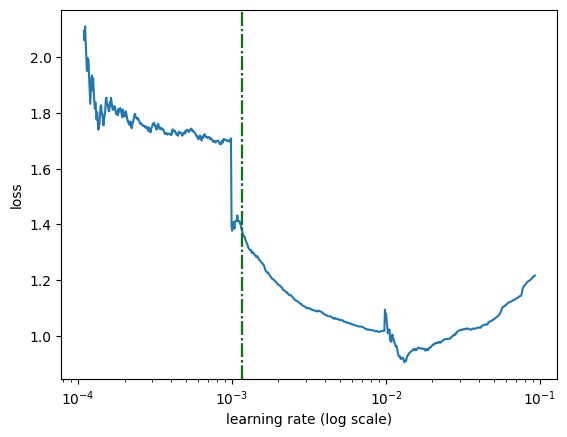

In [25]:
traingen = TrainingDataGenerator(df=train_df, crops= crops,
                             batch_size = BATCH,
                             y_col = {'id': 'id', 'domain': 'domain', 
                                      'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                             X_col = {'path': 'path', 'Night': 'Night'},
                             model_name="DenseNet201", shuffle = True, 
                             INSERTS=INSERTS, SPP_BAL=SPP_BAL, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                             batch_size = BATCH,
                             y_col = {'id': 'id', 'domain': 'domain', 
                                      'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                             X_col = {'path': 'path'},
                             model_name="DenseNet201",
                             shuffle = True)

STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(traingen, start_lr=1e-4, end_lr=1e-1, epochs=3, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valgen)
print("Fold: " + str(split))
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=5, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=45, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
axs = plot_loss()
axs.axvline(x=best_lr, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

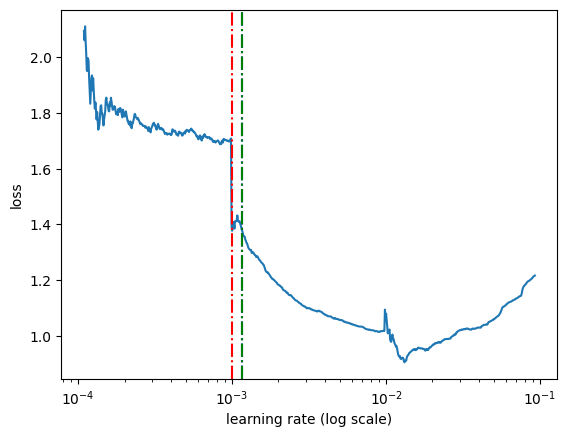

In [73]:
axs = plot_loss()
axs.axvline(x=1.00001e-3, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

In [66]:
def fig_loss(best_lr, best_2, best_3, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    
    ax.axvline(x=best_lr, c='r', linestyle='-.')
    ax.axvline(x=best_2, c='b', linestyle='-.')
    ax.axvline(x=best_3, c='g', linestyle='-.')
    return(f)

Best lr: 0.0011672509
Best lr2: 0.0011672509
Best lr3: 0.0011672509


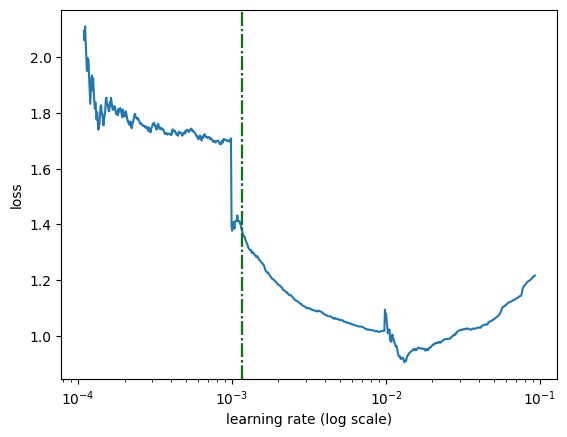

In [67]:
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=5, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=45, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
fig = fig_loss(best_lr, best_2, best_3)

In [68]:
fig.savefig('Fig1.png')

In [ ]:
traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                 batch_size = BATCH,
                                 y_col = {'id': 'id', 'domain': 'domain', 
                                          'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                 X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                 model_name="DenseNet201",
                                 shuffle = True, inserts=True, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                 batch_size = BATCH,
                                 y_col = {'id': 'id', 'domain': 'domain', 
                                          'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                 X_col = {'path': 'path'},
                                 model_name="DenseNet201",
                                 shuffle = True)

history = model.fit(traingen, epochs=1, validation_data=valgen)

/tmp/ipykernel_17960/1031162802.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_tuple = np.asarray([self.__get_insert_input(x) for x in x_batches])
2024-04-29 12:50:39.177115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 180/1250 [===>..........................] - ETA: 9:32 - loss: 2.0685 - accuracy: 0.3079 - precision: 0.5298 - recall: 0.0918

Best lr: 0.000103883955
Best lr2: 0.0010483077
Best lr3: 0.010331993


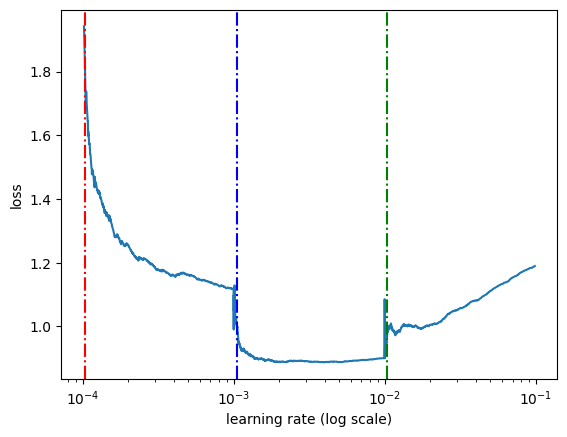

In [25]:
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=50, n_skip_end=1500, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=1300, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
axs = plot_loss()
axs.axvline(x=best_lr, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

In [ ]:
train_weights, train_sample = get_train_weights(train_df)
train_weights.pop(18)
train_weights.pop(22)
train_weights.pop(23)
train_weights.pop(23)
print("N empties: " + str(train_sample))
night_weights = (get_train_weights(train_df))[0]
night_weights.pop(3)
night_weights.pop(4)
night_weights.pop(5)
night_weights.pop(7)
night_weights.pop(10)
night_weights.pop(27)
night_weights.pop(28)


if group_name in ("CTloc"):
    train_group = np.unique(group[train_index])
    val_group = np.unique(group[val_index])
    train_empties=empties.loc[empties['Camera_loc'].isin(train_group)]
    val_empties = empties.loc[empties['Camera_loc']. isin(val_group)]
    val_empties['id']=-2
else:
    train_empties = empties.copy()
train_empties=train_empties.sample(train_sample, replace=True)
train_empties['id']=-1


add_empties = [train_df, train_empties] #, val_empties]
train_df = pd.concat(add_empties)

traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                     model_name="DenseNet201",
                                     shuffle = True, inserts=True, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)

STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(traingen, start_lr=1e-4, end_lr=1e-1, epochs=3, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valgen)
print("Fold: " + str(split))
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=5, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=45, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
axs = plot_loss()
axs.axvline(x=best_lr, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(traingen, start_lr=1e-5, end_lr=1, epochs=5, steps_per_epoch=STEPS_PER_EPOCH)
fig = plot_loss()
best_lr = lr_finder.get_best_lr(sma=20)
print("Best lr: " + str(best_lr), flush=True)

In [ ]:
traingen = TrainingDataGenerator(df=bal_df, crops= crops,
                                         batch_size = BATCH,
                                         y_col = {'id': 'id', 'domain': 'domain', 
                                                  'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                         X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                         model_name="DenseNet201",
                                         shuffle = True, inserts=False) #, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)

In [ ]:
axs = plot_loss()
axs.axvline(x=0.005, c='g', linestyle='-.')
print(lr_finder.get_best_lr(n_skip_beginning=20, n_skip_end=290, sma=20))

In [ ]:
for split, (train_index, val_index) in enumerate(kfold.split(df, Y, group)):
    
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

    y_train = np.array(train_df['id'])

  #  val_group = np.unique(group[val_index])
  #  empties = empties.loc[empties['Camera_loc']. isin(val_group)]
    empties=empties.sample(1000, replace=False)
    add_empties = [train_df, empties]
    train_df = pd.concat(add_empties)

#    paths, X_train, y_train = get_data(train_df)
 #   testpaths, X_test, y_test = get_data(val_df)
    
    traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                     model_name="DenseNet201",
                                     shuffle = True, inserts=False)
    valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)